# Task 7.2. Non-local means
---
***Author: Piotr Skalski***

## 1. Imports

In [20]:
import numpy as np
from scipy.stats import multivariate_normal
import scipy.io as sio
import cv2
import os
import pprint
from tqdm import tqdm
import re
from numpy.linalg import norm
import scipy.ndimage.filters as fi

import display_util
import math

import matplotlib.pyplot as plt
%matplotlib inline

## 2. Primary settings

In [2]:
SOURCE_DIR = "./../data/"
DATA = "MR_data.mat"
NEIGHBORHOOD_SIZE = (5, 5)
SIMILARITY_SIZE = (11, 11)

## 3. Loading data

In [3]:
# building path to data
data_path = os.path.join(SOURCE_DIR, DATA)
# loading data
data = sio.loadmat(data_path)

### 3.1. Data overview

In [4]:
# Key list of data dictionary
pprint.pprint(list(data.keys()))

['I_noisy1',
 '__version__',
 '__globals__',
 'I_noisefree',
 '__header__',
 'I_noisy2',
 'I_noisy4',
 'I_noisy3']


### 3.2. Filtering data

In [5]:
# Filtering data via regex
key_form = p = re.compile('^__.+__$')
# Definition of lists storing image data and their names
images = []
image_names = []

for key, value in data.items():
    if(key_form.match(key) is None):
        print("Image name: {}, image size: {}".format(key, value.shape))
        image_names.append(key)
        images.append(value)

Image name: I_noisy1, image size: (256, 256)
Image name: I_noisefree, image size: (256, 256)
Image name: I_noisy2, image size: (256, 256)
Image name: I_noisy4, image size: (512, 512)
Image name: I_noisy3, image size: (560, 560)


### 3.3. Display images

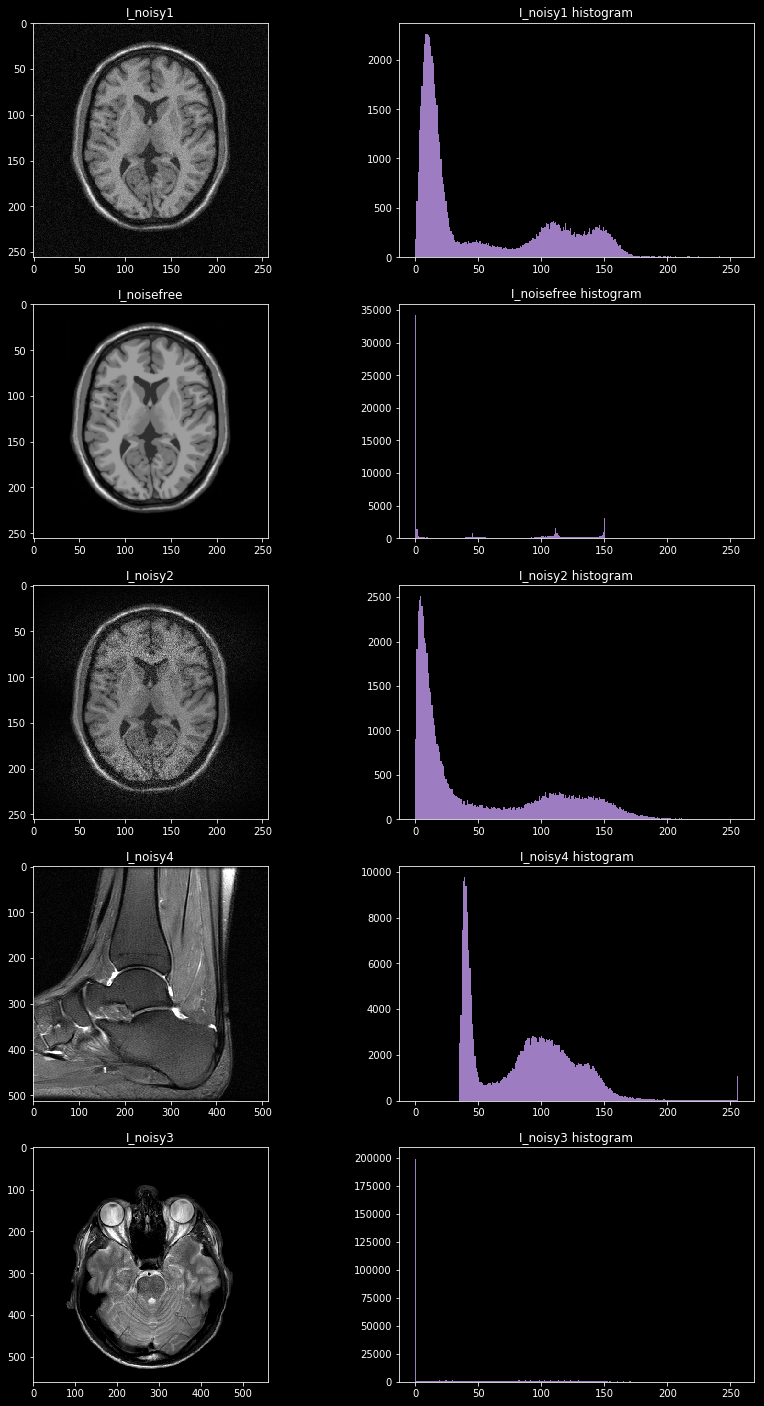

In [6]:
display_util.images_with_histograms(files_list=images, names_list=image_names)

## 4. Use of the built-in function

In [7]:
output_buildin = [cv2.fastNlMeansDenoising(np.uint8(image), None, 10, 7, 21) for image in images]

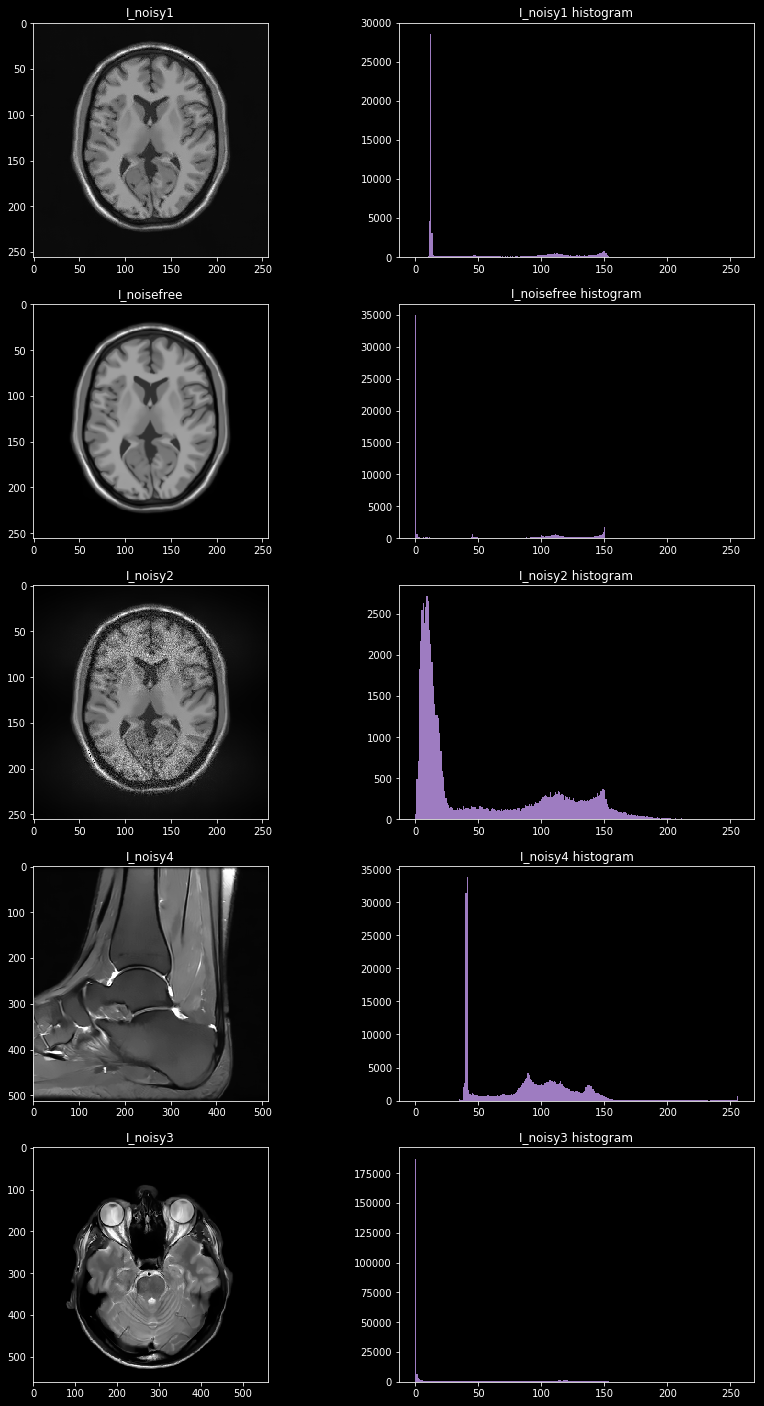

In [8]:
display_util.images_with_histograms(files_list=output_buildin, names_list=image_names)

## 5. Own implementation

### 5.1. Matlab to python colfilt polyfill

In [9]:
def rolling_window(a, shape):
    s = (a.shape[0] - shape[0] + 1,) + (a.shape[1] - shape[1] + 1,) + shape
    strides = a.strides + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=s, strides=strides)

In [10]:
def python_colfilt(data, window_shape, func, args):
    # acquisition of window size and image dimensions
    (window_height, window_width) = window_shape
    (data_rows, data_columns) = data.shape
    
    # preparation of memory for the returned array
    output = np.zeros(data.shape)
    
    # calculation of padding size
    vertical_padding = window_height // 2
    horizontal_padding = window_width // 2
    
    # addition of padding
    data_with_padding = np.pad(data, [(vertical_padding, vertical_padding), (horizontal_padding, horizontal_padding)], 
                               mode='constant', constant_values=0)
    
    # strides
    strides = rolling_window(data_with_padding, window_shape)
    
    for raw_inx in range(data_rows):
        for column_idx in range(data_columns):
            output[raw_inx, column_idx] = func(strides[raw_inx, column_idx], *args)
            
    return output

### 5.2. Simple stride convolution 2D

In [11]:
def simple_stride_conv2d(stride, kernel):
    return np.multiply(stride, kernel).sum()

### 5.3. Generate distance matrix

In [12]:
def generate_dist_matrix(shape):
    (height, width) = shape
    mid_index = np.asarray(shape) // 2
    A = np.arange(height).reshape(height, 1)
    B = np.arange(width).reshape(1, width)
    
    A -= mid_index[0]
    B -= mid_index[1]
    
    return np.power(np.power(A, 2) + np.power(B, 2), 0.5)

### 5.3. Generate gaussian kernel

In [13]:
def generate_gaussian_kernel(size, mu, sigma):
    x, y = np.mgrid[-1.0:1.0:(size[1] * 1j), -1.0:1.0:(size[0] * 1j)]
    xy = np.column_stack([x.flat, y.flat])
    mu = np.array([mu, mu])
    sigma = np.array([sigma, sigma])
    covariance = np.diag(sigma**2)
    z = multivariate_normal.pdf(xy, mean=mu, cov=covariance)
    z = z.reshape(x.shape)
    return z/z.sum()

### 5.4. NLM

In [14]:
def inner_nlm_conv(image_part, gaussian_kernel, gaussian_Nx, h):
    gaussian_Np = np.multiply(image_part, gaussian_kernel)
    return norm(gaussian_Np - gaussian_Nx)

In [15]:
def nlm_conv(image_part, gaussian_kernel, h):
    image_part_size = image_part.shape
    neighborhood_size = gaussina_kernel.shape
    image_part_center = np.asarray(image_part_size) // 2
    neighborhood_center = np.asarray(neighborhood_size) // 2
    
    Nx = image_part[image_part_center[0] - neighborhood_center[0]:image_part_center[0] + neighborhood_center[0] + 1,
                    image_part_center[1] - neighborhood_center[1]:image_part_center[1] + neighborhood_center[1] + 1]
    
    gaussian_Nx = np.multiply(Nx, gaussian_kernel)
    w = python_colfilt(image_part, neighborhood_size, inner_nlm_conv, [gaussian_kernel, gaussian_Nx, h])
    w = np.exp(-np.power(w, 2)/h)
    w = w/w.sum()
    return simple_stride_conv2d(image_part, w)

In [16]:
GAUSSIAN_SIGMA = 1
H = 10
gaussina_kernel = generate_gaussian_kernel(NEIGHBORHOOD_SIZE, 0, GAUSSIAN_SIGMA)

In [17]:
nlm_noisy1 = python_colfilt(images[0], SIMILARITY_SIZE, nlm_conv, [gaussina_kernel, H])
nlm_noisy2 = python_colfilt(images[2], SIMILARITY_SIZE, nlm_conv, [gaussina_kernel, H])

In [18]:
images_comp = [
    images[0],
    nlm_noisy1,
    images[2],
    nlm_noisy2,
]

images_names = [
    "I_noisy1 orginal",
    "I_noisy1 nlm",
    "I_noisy2 orginal",
    "I_noisy2 nlm"
]

## 6. Comparison of original images with nlm results

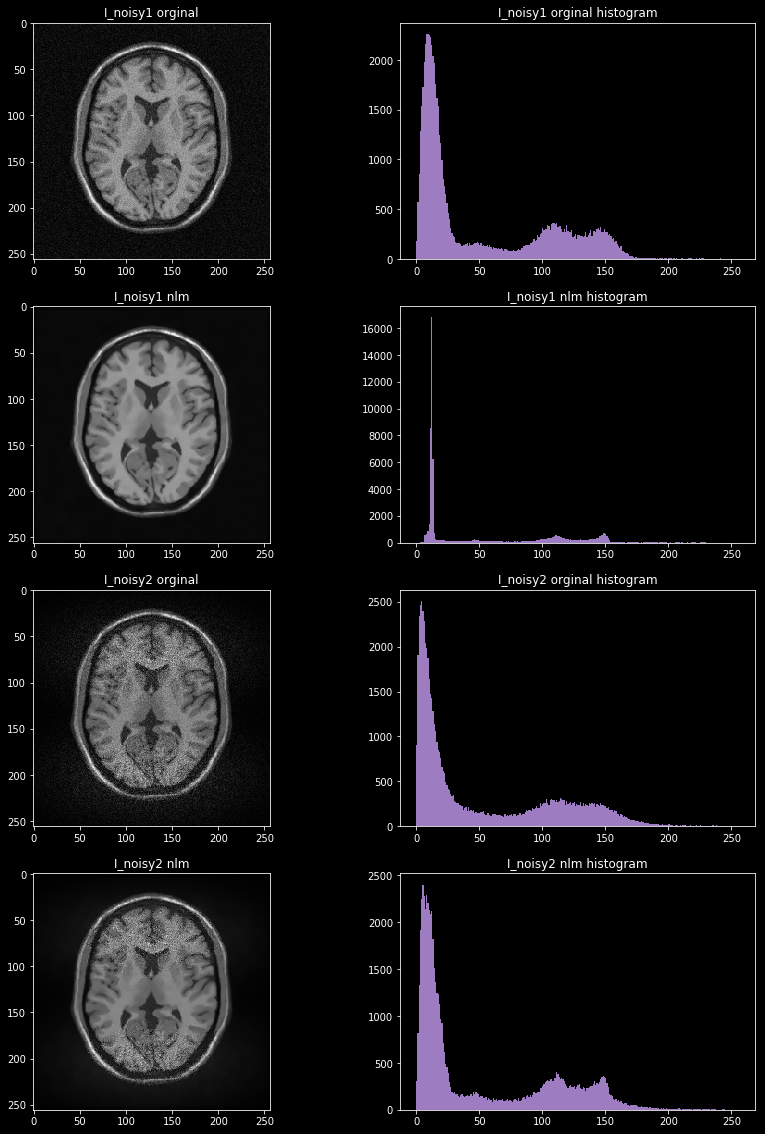

In [19]:
display_util.images_with_histograms(files_list=images_comp, names_list=images_names)

## 7. Resources

1. [Gentle Introduction to Vector Norms in Machine Learning](https://machinelearningmastery.com/vector-norms-machine-learning/)